In [20]:
import sys
import os

sys.path.insert(0, ('/').join(os.getcwd().split('/')[:-1]))
from py_wave_propagator import free_space_prop
from py_wave_propagator import volume_prop

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from matplotlib import animation
import cv2
from scipy.ndimage import gaussian_filter, median_filter
from scipy.interpolate import RegularGridInterpolator
import h5py
from scipy.signal.windows import tukey

# Propagation to a non-parallel/oblique/angled plane

0. Confirm steps
1. Show results

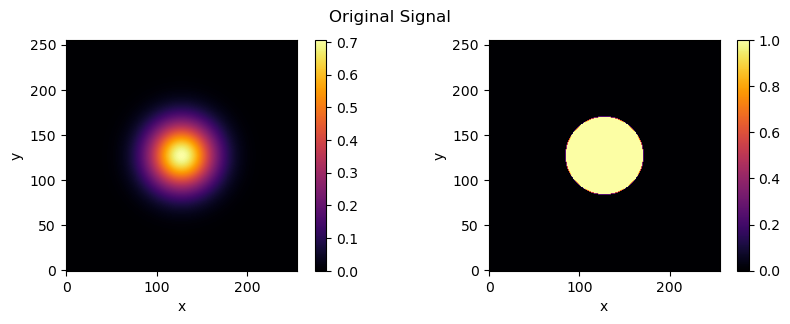

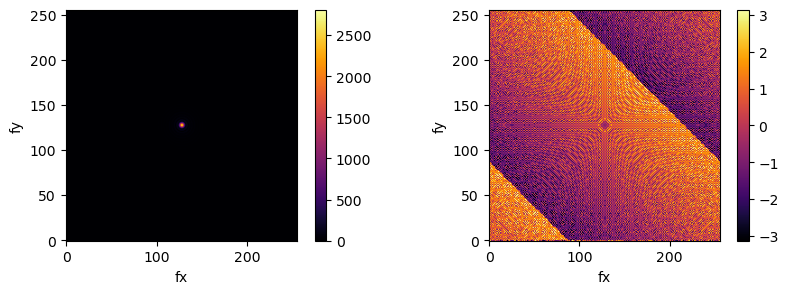

In [2]:
# generating a gaussian beam

def gaussian_beam(x, y, wavelength, waist_size, z, phase=0):
    k = 2 * np.pi / wavelength
    zR = np.pi * waist_size**2 / wavelength
    w_z = waist_size * np.sqrt(1 + (z / zR)**2)
    R_z = z * (1 + (zR / z)**2)
    gouy_phase = np.arctan(z / zR)
    
    w_0 = waist_size / np.sqrt(2)
    # phase_term = np.exp(1j * (k * z - k * x**2 / (2 * R_z) - gouy_phase + phase))
    thresh = x**2 + y**2 < waist_size
    phase_term = np.exp(1j * 1 * thresh)

    
    return (w_0 / w_z) * np.exp(-((x**2 + y**2) / w_z**2)) * phase_term

# Parameters
wl = 650*1e-6  # wavelength (in mm)
numPx = [256, 256]
sizePx = [0.02, 0.02]
waist_size = 0.75  # waist size of the beam (in mm)
z = 10  # propagation distance (in mm)

# Grid
x = np.linspace(-1*sizePx[0]*numPx[0]/2, sizePx[0]*numPx[0]/2, numPx[0])
y = np.linspace(-1*sizePx[1]*numPx[1]/2, sizePx[1]*numPx[1]/2, numPx[1])
X, Y = np.meshgrid(x, y)

# Generate Gaussian beam
gaussian_field = gaussian_beam(X, Y, wl, waist_size, z)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

cb = axs[0].imshow((np.abs(gaussian_field)), 
        #    extent=(-5, 5, -5, 5), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[0])
# axs[0].set_title('Amplitude | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

cb = axs[1].imshow((np.angle(gaussian_field)), 
        #    extent=(-5, 5, -5, 5), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[1])
# axs[1].set_title('Phase | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.suptitle('Original Signal')

plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

cb = axs[0].imshow(np.abs(np.fft.fftshift(np.fft.fft2(gaussian_field))), 
        #    extent=(-5, 5, -5, 5), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[0])
# axs[0].set_title('Amplitude | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
axs[0].set_xlabel('fx')
axs[0].set_ylabel('fy')

cb = axs[1].imshow(np.angle(np.fft.fftshift(np.fft.fft2(gaussian_field))), 
        #    extent=(-5, 5, -5, 5), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[1])
# axs[1].set_title('Phase | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
axs[1].set_xlabel('fx')
axs[1].set_ylabel('fy')

plt.show()


In [73]:
# # rectangular aperture

# # Parameters
# wl = 650*1e-9  # wavelength (in m)
# numPx = [256, 256]
# sizePx = [0.02e-3, 0.02e-3]
# z = 30e-3  # propagation distance (in m)

# k = 2*np.pi/wl
# X, Y = np.meshgrid(np.arange(-128, 128)*sizePx[0], np.arange(-128, 128)*sizePx[1], indexing='ij')

# rect_field = np.exp(1j*k*z)*np.exp(1j*k/(2*z)*(X**2 + Y**2))/(1j*wl*z)*(4*0.02e-3)**2*np.sinc(4*0.02e-3*X/(wl*z))*np.sinc(4*0.02e-3*Y/(wl*z))

# # Plot
# fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# cb = axs[0].imshow(np.log10(np.abs(rect_field)**2), vmin=-6,
#         #    extent=(-5, 5, -5, 5), 
#            cmap='inferno', origin='lower')
# fig.colorbar(cb, ax=axs[0])
# # axs[0].set_title('Amplitude | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
# axs[0].set_xlabel('x')
# axs[0].set_ylabel('y')

# cb = axs[1].imshow((np.angle(rect_field)), 
#         #    extent=(-5, 5, -5, 5), 
#            cmap='inferno', origin='lower')
# fig.colorbar(cb, ax=axs[1])
# # axs[1].set_title('Phase | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
# axs[1].set_xlabel('x')
# axs[1].set_ylabel('y')

# plt.suptitle('Original Signal')

# plt.show()

# fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# cb = axs[0].imshow(np.abs(np.fft.fftshift(np.fft.fft2(rect_field))), 
#         #    extent=(-5, 5, -5, 5), 
#            cmap='inferno', origin='lower')
# fig.colorbar(cb, ax=axs[0])
# # axs[0].set_title('Amplitude | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
# axs[0].set_xlabel('fx')
# axs[0].set_ylabel('fy')

# cb = axs[1].imshow(np.angle(np.fft.fftshift(np.fft.fft2(rect_field))), 
#         #    extent=(-5, 5, -5, 5), 
#            cmap='inferno', origin='lower')
# fig.colorbar(cb, ax=axs[1])
# # axs[1].set_title('Phase | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
# axs[1].set_xlabel('fx')
# axs[1].set_ylabel('fy')

# plt.show()

In [72]:
# wave_obj = free_space_prop.Wave2d(
#     numPx = [256, 256], 
#     sizePx = [0.02e-3, 0.02e-3], 
#     wl = wl
# )

# rect_field = np.zeros([256, 256])
# rect_field[124:-124, 124:-124] = 1.

# wave_obj.wavefield(rect_field)
# rect_field = wave_obj.propogate(27e-3)

# # Plot
# fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# cb = axs[0].imshow(np.log10(np.abs(rect_field)**2), vmin=-6,
#         #    extent=(-5, 5, -5, 5), 
#            cmap='inferno', origin='lower')
# fig.colorbar(cb, ax=axs[0])
# # axs[0].set_title('Amplitude | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
# axs[0].set_xlabel('x')
# axs[0].set_ylabel('y')

# cb = axs[1].imshow((np.angle(rect_field)), 
#         #    extent=(-5, 5, -5, 5), 
#            cmap='inferno', origin='lower')
# fig.colorbar(cb, ax=axs[1])
# # axs[1].set_title('Phase | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
# axs[1].set_xlabel('x')
# axs[1].set_ylabel('y')

# plt.suptitle('Original Signal')

# plt.show()

# fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# cb = axs[0].imshow(np.abs(np.fft.fftshift(np.fft.fft2(rect_field))), 
#         #    extent=(-5, 5, -5, 5), 
#            cmap='inferno', origin='lower')
# fig.colorbar(cb, ax=axs[0])
# # axs[0].set_title('Amplitude | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
# axs[0].set_xlabel('fx')
# axs[0].set_ylabel('fy')

# cb = axs[1].imshow(np.angle(np.fft.fftshift(np.fft.fft2(rect_field))), 
#         #    extent=(-5, 5, -5, 5), 
#            cmap='inferno', origin='lower')
# fig.colorbar(cb, ax=axs[1])
# # axs[1].set_title('Phase | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
# axs[1].set_xlabel('fx')
# axs[1].set_ylabel('fy')

# plt.show()

# Estimating GT at rotated plane

Translate by +/- 1.2800 mm


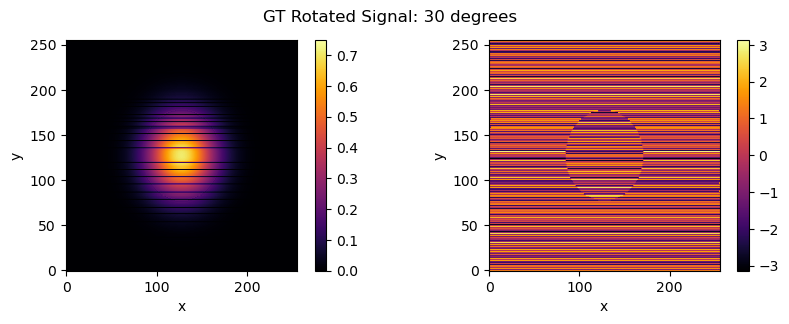

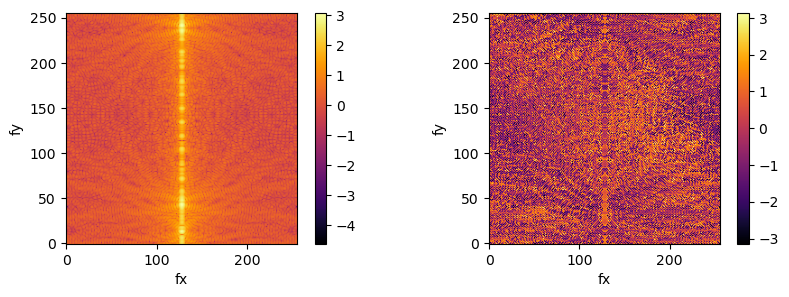

In [187]:
## GT simulation
rot_x = 30 # degrees
max_d = (0.02e-3*256/2)*np.sin(rot_x*np.pi/180)

del_d = max_d/128
del_x = del_d/np.sin(rot_x*np.pi/180)
del_y = del_d/np.tan(rot_x*np.pi/180)

print(f'Translate by +/- {max_d/1e-3:.4f} mm')

steps = 256
wl = 650*1e-9

wave_obj = free_space_prop.Wave2d(
    numPx = [256, 256], 
    sizePx = [0.02e-3, 0.02e-3], 
    wl = wl
)

wave_obj.wavefield(gaussian_field)
gt_rot_wave = np.zeros_like(gaussian_field)

wave_z_obl = []
for i, dist2 in enumerate(np.linspace(-max_d, max_d, steps)):
    wave_z_temp = wave_obj.propogate(dist2)
    gt_rot_wave[int(128*(0.02e-3*256/2 - (i+1)*del_x)/(0.02e-3*256/2)) + 128, :] = wave_z_temp[int(128*(np.cos(rot_x*np.pi/180)*0.02e-3*256/2 - (i+1)*del_y)/(0.02e-3*256/2)) + 128, :]

# gt_rot_wave = gaussian_filter(gt_rot_wave, 1, truncate=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
cb = axs[0].imshow((np.abs(gt_rot_wave)), 
                   vmax=0.75, vmin=0, 
        #    extent=(-5, 5, -5, 5), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[0])
# axs[0].set_title('Amplitude | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
# axs[0].grid()

cb = axs[1].imshow((np.angle(gt_rot_wave)), 
        #    extent=(-5, 5, -5, 5), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[1])
# axs[1].set_title('Phase | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.suptitle(f'GT Rotated Signal: {rot_x} degrees')

plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
cb = axs[0].imshow(np.log10(np.abs(np.fft.fftshift(np.fft.fft2(gt_rot_wave)))), 
        #    extent=(-5, 5, -5, 5), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[0])
# axs[0].set_title('Amplitude | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
axs[0].set_xlabel('fx')
axs[0].set_ylabel('fy')

cb = axs[1].imshow(np.angle(np.fft.fftshift(np.fft.fft2(gt_rot_wave))), 
        #    extent=(-5, 5, -5, 5), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[1])
# axs[1].set_title('Phase | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
axs[1].set_xlabel('fx')
axs[1].set_ylabel('fy')

plt.show()

## 1. Transformation to non-parallel plane

/tmp/ipykernel_6139/1513232024.py:17: RuntimeWarning: divide by zero encountered in log10
  surf = ax.plot_surface(U_hat, V_hat, np.clip(np.log10(np.abs(wave_z_freq)), -2, 4), cmap=cm.coolwarm,


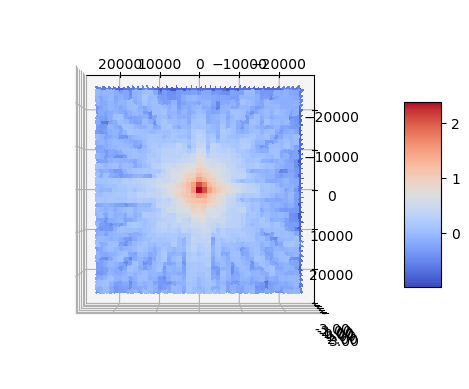

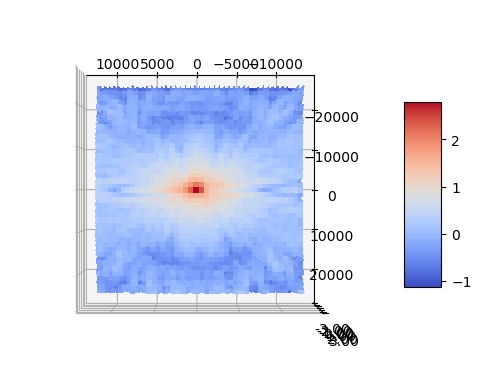

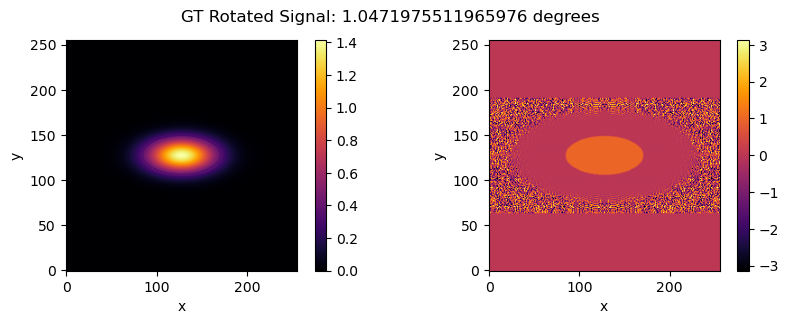

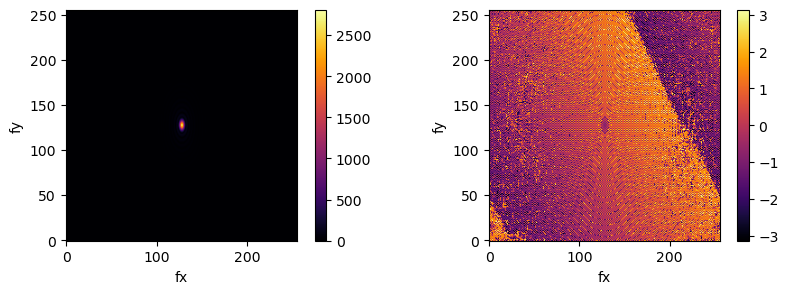

In [85]:
wl = 650*1e-9
rot_x = 60*np.pi/180 # degrees

T_inv = np.array([[np.cos(rot_x), 0, np.sin(rot_x)], 
                  [0, 1, 0], 
                  [-1*np.sin(rot_x), 0, np.cos(rot_x)]])


u_hat = v_hat = np.fft.fftshift(np.fft.fftfreq(256, 0.02e-3))
U_hat, V_hat = np.meshgrid(u_hat, v_hat, indexing='ij')

wave_z_freq = np.fft.fftshift(np.fft.fft2(np.pad(gaussian_field, 0)))
W_hat = np.sqrt(1/((wl)**2) - U_hat**2 - V_hat**2)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(U_hat, V_hat, np.clip(np.log10(np.abs(wave_z_freq)), -2, 4), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-3, 3)

# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(elev=90, azim=90, roll=0)
plt.show()

# interp = RegularGridInterpolator((u_hat, v_hat), wave_z_freq, method='linear', bounds_error=False, fill_value=None)
interp2_re = RegularGridInterpolator((u_hat, v_hat), wave_z_freq.real, method='cubic', bounds_error=False, fill_value=0)
interp2_im = RegularGridInterpolator((u_hat, v_hat), wave_z_freq.imag, method='cubic', bounds_error=False, fill_value=0)


u_hat = np.fft.fftshift(np.fft.fftfreq(int(256*np.cos(rot_x)), 0.02e-3))
v_hat = np.fft.fftshift(np.fft.fftfreq(256, 0.02e-3))
U_hat, V_hat = np.meshgrid(u_hat, v_hat, indexing='ij')
W_hat = np.sqrt(1/((wl)**2) - U_hat**2 - V_hat**2)

U = U_hat*T_inv[0, 0] + V_hat*T_inv[0, 1] + W_hat*T_inv[0, 2]
V = U_hat*T_inv[1, 0] + V_hat*T_inv[1, 1] + W_hat*T_inv[1, 2]
W = U_hat*T_inv[2, 0] + V_hat*T_inv[2, 1] + W_hat*T_inv[2, 2]

# J = np.abs(T_inv[0, 0] - U_hat/W_hat*T_inv[0, 2])

# wave_z_freq_interp_fft = np.pad((interp((U - np.sin(rot_x*np.pi/180)/wl, V))), 0)
# wave_z_freq_interp = np.fft.ifft2(np.fft.ifftshift(wave_z_freq_interp_fft))
wave_z_freq_interp_fft = np.pad(interp2_re((U - np.sin(rot_x)/wl, V)) + 1j*interp2_im((U - np.sin(rot_x)/wl, V)), 0)
wave_z_freq_interp = np.fft.ifft2(np.fft.ifftshift(np.where(np.abs(wave_z_freq_interp_fft) > 0.5, wave_z_freq_interp_fft, 0.)))

wave_z_freq_interp = np.pad(wave_z_freq_interp, ((64, 64), (0, 0)))
# (256 - int(256*np.cos(rot_x)/2))
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(U - np.sin(rot_x)/wl, V, np.clip(np.log10(np.abs(wave_z_freq_interp_fft)), -2, 4), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-3, 3)

# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(elev=90, azim=90, roll=0)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
cb = axs[0].imshow((np.abs(wave_z_freq_interp)), 
                #    vmax=0.75, vmin=0,
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[0])
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')


cb = axs[1].imshow((np.angle(wave_z_freq_interp)), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[1])
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.suptitle(f'GT Rotated Signal: {rot_x} degrees')

plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
cb = axs[0].imshow((np.abs(np.fft.fftshift(np.fft.fft2(wave_z_freq_interp)))), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[0])
axs[0].set_xlabel('fx')
axs[0].set_ylabel('fy')

cb = axs[1].imshow(np.angle(np.fft.fftshift(np.fft.fft2(wave_z_freq_interp))), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[1])
axs[1].set_xlabel('fx')
axs[1].set_ylabel('fy')

plt.show()

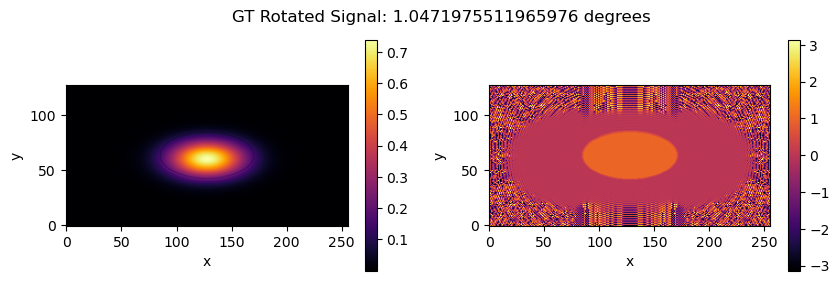

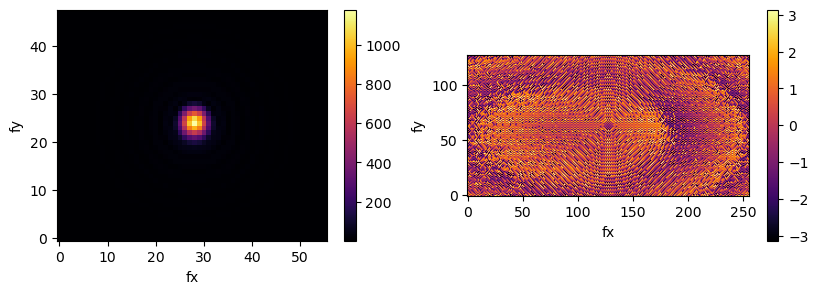

In [27]:
wave_z_freq_interp = np.fft.ifft2(np.fft.ifftshift((wave_z_freq_interp_fft)))[:128]

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
cb = axs[0].imshow((np.abs(wave_z_freq_interp)), 
                #    vmax=0.75, vmin=0,
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[0])
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')


cb = axs[1].imshow((np.angle(wave_z_freq_interp)), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[1])
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.suptitle(f'GT Rotated Signal: {rot_x} degrees')

plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
cb = axs[0].imshow((np.abs(np.fft.fftshift(np.fft.fft2(wave_z_freq_interp))))[40:-40, 100:-100], 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[0])
axs[0].set_xlabel('fx')
axs[0].set_ylabel('fy')

cb = axs[1].imshow(np.angle(np.fft.fftshift(np.fft.fft2(wave_z_freq_interp))), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[1])
axs[1].set_xlabel('fx')
axs[1].set_ylabel('fy')

plt.show()

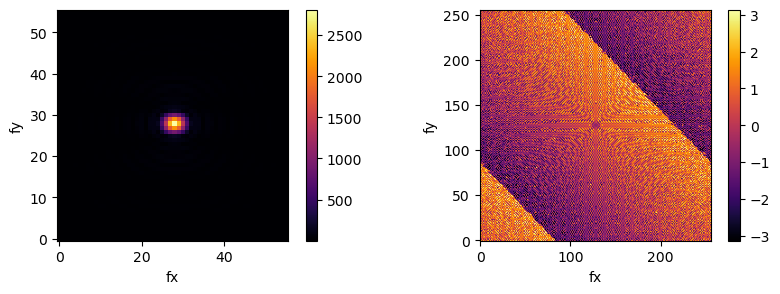

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 3))
# cb = axs[0].imshow((np.abs(((wave_z_freq_interp_fft))))[100:-100, 100:-100], 
#            cmap='inferno', origin='lower')
# fig.colorbar(cb, ax=axs[0])
# axs[0].set_xlabel('fx')
# axs[0].set_ylabel('fy')

# cb = axs[1].imshow(np.angle(((wave_z_freq_interp_fft))), 
#            cmap='inferno', origin='lower')
# fig.colorbar(cb, ax=axs[1])
# axs[1].set_xlabel('fx')
# axs[1].set_ylabel('fy')

# plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
cb = axs[0].imshow((np.abs(np.fft.fftshift(np.fft.fft2(wave_z_freq_interp))))[450:-450, 450:-450], 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[0])
axs[0].set_xlabel('fx')
axs[0].set_ylabel('fy')

cb = axs[1].imshow(np.angle(np.fft.fftshift(np.fft.fft2(wave_z_freq_interp))), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[1])
axs[1].set_xlabel('fx')
axs[1].set_ylabel('fy')

plt.show()